# Projet
*Les premières parties peuvent être exécutée par un kernel différent: à la fin de chaque partie, les fichiers sont stockés, et la mémoire vive n'est pas utilisée d'une partie à l'autre*

Après l'analyse, les parties sont interdépendantes

## Collecte de données

In [1]:
!pip install sparqlwrapper
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# Get casino image
query = """SELECT ?image {
  ?data wdt:P31 wd:Q133215;
        wdt:P18 ?image
}
LIMIT 128"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["image"]["value"],
        )
    )

In [3]:
import pandas as pd
dataframe = pd.DataFrame(array, columns=["image"])
dataframe = dataframe.astype(
    dtype={"image": "<U200"}
)
dataframe

,image
0,http://commons.wikimedia.org/wiki/Special:File...
1,http://commons.wikimedia.org/wiki/Special:File...
2,http://commons.wikimedia.org/wiki/Special:File...
3,http://commons.wikimedia.org/wiki/Special:File...
4,http://commons.wikimedia.org/wiki/Special:File...
...,...
123,http://commons.wikimedia.org/wiki/Special:File...
124,http://commons.wikimedia.org/wiki/Special:File...
125,http://commons.wikimedia.org/wiki/Special:File...
126,http://commons.wikimedia.org/wiki/Special:File...


In [4]:
import os
try:
    os.mkdir('images')
except:
    pass

Nous allons écrire une méthode pour extraire les exifs

Nous allons maintenant télécharger les images

In [5]:
import requests
import shutil
import os
import json

count = 0
def download_image(url):
    global metadata, count
    if count % 10 == 0:
        print("Téléchargé ", count, " images") 
    count += 1

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        nom = os.path.basename(url)[-30:]
        chemin = "images/"+nom
        with open(chemin, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code

In [6]:
print("Début du téléchargement")
dataframe.image.apply(download_image)

Début du téléchargement
Téléchargé  0  images
Téléchargé  10  images
Téléchargé  20  images
Téléchargé  30  images
Téléchargé  40  images
Téléchargé  50  images
Téléchargé  60  images
Téléchargé  70  images
Téléchargé  80  images
Téléchargé  90  images
Téléchargé  100  images
Téléchargé  110  images
Téléchargé  120  images


0      200
1      200
2      200
3      200
4      200
      ... 
123    200
124    200
125    200
126    200
127    200
Name: image, Length: 128, dtype: int64

## Étiquetage et annotation

On enregistre les exifs

In [7]:
!pip install scikit-learn
import os, sys, json
from PIL import Image
from PIL.ExifTags import TAGS
import numpy
import math
from sklearn.cluster import KMeans


def extraire_donnees(image_chemin):
    imgfile = Image.open(image_chemin)
    try:
        exif_data = imgfile._getexif()
    except:
        print(f"les EXIFs n'ont pas pu être extraits depuis {image_chemin}")
        exif_data = {}
    image_metadata = dict()
    if exif_data:
        for tag, value in exif_data.items():
            if(isinstance(value, bytes)):
                continue
            if (not isinstance(value, int)) and (not isinstance(value, float)):
                value = f"{value}"
            if tag in TAGS:
                image_metadata[TAGS[tag]] = value
    return image_metadata
print("Fonction extraction OK")

Defaulting to user installation because normal site-packages is not writeable
Fonction extraction OK


On utilise KMeans pour avoir 2 clusters par image

In [8]:
def extraire_couleurs(image_chemin):
    imgfile = Image.open(image_chemin)
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    print(image_chemin)
    clusters = KMeans(n_clusters=2, n_init=2)
    couleurs = []
    try :
        clusters.fit(numarray)
        for i in range(2):
            couleur = ("#%02x%02x%02x"
                % (
                    math.ceil(clusters.cluster_centers_[i][0]),
                    math.ceil(clusters.cluster_centers_[i][1]),
                    math.ceil(clusters.cluster_centers_[i][2]),
                ))
            couleurs.append(couleur)
    except:
        print(f"les couleurs n'ont pas pu être extraits depuis {image_chemin}")
        couleur = "#00000"
        for i in range(2):
            couleurs.append(couleur)
    print(couleurs)
    return couleurs

On ajoute des tags rentrés à l'avance depuis user_inputs, qui représente des entrées d'utilisateurs.

In [9]:
def ajout_tag(dat, filename, tags):
    dat[filename]['tags'] = tags
    return dat

def lire_entree(dat, filename):
    input_file = "user_input/"+filename+".txt"
    tagstr = ""
    if os.path.exists(input_file):
        with open(input_file, 'r') as fichier:
            tagstr = fichier.read()
    tags = [partie for partie in tagstr.split() if partie]
    return ajout_tag(dat, filename, tags)

On construit un JSON en extrayant les couleurs, les exifs, et les tags

In [13]:
json_dat = {}
for filename in os.listdir("images"):
    json_dat[filename] = {
        'exif': extraire_donnees("images/"+filename),
        'color': extraire_couleurs("images/"+filename)
    }
    json_dat = lire_entree(json_dat, filename)
print(json_dat)
json.dump(json_dat, open("img_data.json", "w"), indent=2)

images/%20Casino%2C%20Las%20Vagas.jpg
['#4a4747', '#92a0b0']
images/%20Casino%2C%20Las%20Vegas.jpg
['#565254', '#b2cae5']
images/%20Foto%20postcard%201940s.jpg
['#d4d5d6', '#4a4b4d']
images/%20Montbenon%2C%20Lausanne.jpg
['#1e1b19', '#939da4']
images/%20Neuenahr%20Kurhaus%2030.JPG
['#beb8b0', '#313b57']
images/%20Rico%20%28IMG%202934%29.jpg
['#daded8', '#6f7565']
images/%20Savoie%20-Aix-les-Bains.JPG
['#455548', '#a2bed1']
images/%20Station%20hotel%20tower.jpg
['#554c4b', '#b6b7d7']
images/%20Vegas%20December%202013.jpg
['#5f5548', '#b9bec2']
images/%20Vegas%20Wynn%20P4220706.jpg
['#4c5248', '#b0c4d6']
les EXIFs n'ont pas pu être extraits depuis images/%2C%20NV%20HAER%20NV-14-12.tif
images/%2C%20NV%20HAER%20NV-14-12.tif
les couleurs n'ont pas pu être extraits depuis images/%2C%20NV%20HAER%20NV-14-12.tif
['#00000', '#00000']
images/%C3%A1rkert%20kaszin%C3%B3.jpg
['#423f3e', '#a9afb1']
images/-%20en%20Cultuurpaleis%201.jpg
['#869bbb', '#403f43']
images/-%20North%20-%202011-06-04.jpg
['#c

## Analyses de données

Maintenant, on a les données à l'état brut. On va les transformer pour garder des données traitables pour l'analyse. Il faut qu'on convertisse chaque donnée en une valeur traitable pour faire des vecteurs. On commence par une fonction de transformation de la première couleur dominante en tag

In [135]:
!pip install colorsysx

Defaulting to user installation because normal site-packages is not writeable


In [136]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import colorsysx as colorsys

couleurs_tags_possibles = {
    'red': [255, 0, 0],
    'green': [0, 255, 0],
    'blue': [0, 0, 255],
    'yellow': [255, 255, 0],
    'cyan': [0, 255, 255],
    'magenta': [255, 0, 255],
    'black': [0, 0, 0],
    'white': [255, 255, 255]
}

tags_keys = couleurs_tags_possibles.keys()
def rgb_to_hls(color_rgb):
    return colorsys.rgb_to_hls(*[v/255 for v in color_rgb[:3]])

colors_lab = {k: rgb_to_hls(couleurs_tags_possibles[k]) for k in tags_keys}
color_voisins = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(np.array([colors_lab[k] for k in tags_keys]))

def tag_de_couleur(colorhex):
    # hex to rgb: #xxxxxx -> [ x, x, x ]
    hex = colorhex.lstrip('#')
    color = tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))
    
    color_lab = rgb_to_hls(color)
    distances, indices = color_voisins.kneighbors([color_lab])
    nearest_color = list(tags_keys)[indices[0][0]]
    return nearest_color

In [137]:
"""
 single_picdata peut être un dictionnaire {exif, color, tags} ou {}
 La sortie doit être un tableau (ou vecteur) traitable pour l'analyse
"""
def transform_data(single_picdata):
    keys = single_picdata.keys()
    exifs = single_picdata["exif"] if "exif" in keys else {}
    exifkeys = exifs.keys()
    tags = single_picdata["tags"]
    orientation = "unknown"
    if "ExifImageWidth" in exifs and "ExifImageheight" in exifs:
        orientation = "landscape" if exifs["ExifImageWidth"] > exifs["ExifImageHeight"] else "portrait"
    return [
        orientation,
        tag_de_couleur(single_picdata["color"][0]),
        "old" in tags,
        "modern" in tags,
        "architecture" in tags,
        "classy" in tags, 
        "nature" in tags
    ]

On initialise ensuite un tableau avec nos données traitables pour 10 images aléatoires

In [138]:
from random import sample
import json, os

def read_pic_datas(picnames):
    with open('img_data.json', 'r') as f:
        pic_json_data = json.load(f)
    pic_json_keys = pic_json_data.keys()
    res_dat = []
    for picname in picnames:
        single_picdat = pic_json_data[picname] if picname in pic_json_keys else {}
        res_dat.append(transform_data(single_picdat))
    return res_dat

pics = sample(os.listdir("images"), 10)
picdata_matrix = read_pic_datas(pics)

On demande les préférences utilisateur sur ces 10 images

In [139]:
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


In [155]:
import ipywidgets as widgets
from IPython.display import clear_output

pic_output = widgets.Output()

shown_image_idx = 0
likes = [None] * len(pics)

def show(nomfichier):
    global pic_output
    with open("images/"+nomfichier, 'rb') as f:
        shown_image = f.read()
    picwidget = widgets.Image(
        value=shown_image,
    )
    picwidget.layout.height= '150px'
    with pic_output:
        clear_output()
        display(picwidget)

def clear_if_maxed():
    global shown_image_idx
    if shown_image_idx >= len(pics):
        with pic_output:
            clear_output()
            print("Fin de la navigation")
def likeit(_b):
    global shown_image_idx
    clear_if_maxed()
    likes[shown_image_idx] = True
    shown_image_idx += 1
    clear_if_maxed()
    show(pics[shown_image_idx])

def hateit(_b):
    global shown_image_idx, liked
    print("Hate")
    clear_if_maxed()
    likes[shown_image_idx] = False
    shown_image_idx += 1
    clear_if_maxed()
    show(pics[shown_image_idx])

like_button = widgets.Button(
    description='',
    disabled=False,
    button_style='',
    tooltip='Like',
    icon='heart'
)
like_button.style = {'button_color': '#ff4757'}
like_button.on_click(likeit)

hate_button = widgets.Button(
    description='',
    disabled=False,
    button_style='',
    tooltip='Dislike',
    icon='thumbs-down'
)
hate_button.style = {'button_color': '#5352ed'}
hate_button.on_click(hateit)
buttons = widgets.HBox([like_button, hate_button])

display(buttons,pic_output)
show(pics[shown_image_idx])

Output()

In [41]:
print(likes)

[False, False, False, False, False, False, False, True, False, False]


On a donc les données d'un seul utilisateur

## Visualisation des données

In [156]:
!pip install pandas
!pip install matplotlib
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


On commence par coder une visualisation des images par année

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import json
import datetime

annee_actuelle = datetime.datetime.now().year
def get_annee(exif):
    annee = exif["DateTimeOriginal"].split(":")[0] if "DateTimeOriginal" in exif.keys() else '0'
    if int(annee) == 0 or int(annee) > annee_actuelle:
        annee = "Unknown"
    return annee

def images_par_date(exifs, subplot):
    dates = [get_annee(i) for i in exifs]
    int_dates = [int(d) for d in dates if d != "Unknown"]
    annees_idx = [str(i) for i in range(min(int_dates), max(int_dates))]
    frequences_annees = {k: dates.count(k) for k in annees_idx}
    subplot.plot(frequences_annees.keys(), frequences_annees.values())
    subplot.set_xlabel('Années')
    subplot.set_ylabel('Fréquence')
    subplot.set_xticks(annees_idx, [i if int(i) % 5 == 0 else '' for i in annees_idx])
    subplot.set_title(f'Fréquence des années\n(Inconnues: {dates.count("Unknown")})')

On récupère l'orientation des images

In [158]:
def get_orientation(exifs):
    orientation = "unknown"
    if "ExifImageWidth" in exifs and "ExifImageHeight" in exifs:
        orientation = "landscape" if exifs["ExifImageWidth"] > exifs["ExifImageHeight"] else "portrait"
    return orientation

def images_par_orientation(list_exifs, subplot):
    orientations = [get_orientation(exifs) for exifs in list_exifs]
    frequences = {k: orientations.count(k) for k in ["landscape", "portrait", "unknown"]}
    subplot.pie(frequences.values(), labels=frequences.keys(), colors=['r','g','b'], autopct='%1.1f%%')
    subplot.axis('equal')
    subplot.set_title('Fréquence des orientations')        

On récupère les couleurs ou tags dominants

In [159]:
def tag_columns(tags, subplot, title, colorlambda= None):
    frequences = {}
    for tag in tags:
        if tag not in frequences:
            frequences[tag] = 0
        frequences[tag] += 1
    colors = None
    if colorlambda is not None:
        colors = [colorlambda(k) for k in frequences.keys()]
    subplot.bar(frequences.keys(), frequences.values(), color=colors, edgecolor="black")
    subplot.set_title(title)

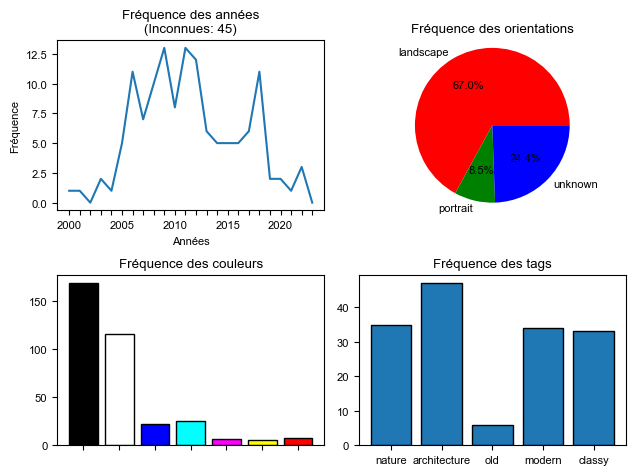

In [160]:
with open('img_data.json', 'r') as f:
    pic_json_data = json.load(f)
pic_exifs = [i["exif"] if i is not None else {} for i in pic_json_data.values()]

font = {'size' : 8}
matplotlib.rc('font', **font)

fig, ((sp1, sp2), (sp3, sp4)) = plt.subplots(2, 2)
images_par_date(pic_exifs, sp1)
images_par_orientation(pic_exifs, sp2)
colortags = [tag_de_couleur(c) for i in pic_json_data.values() for c in i["color"]]
tag_columns(colortags, sp3, "Fréquence des couleurs", lambda c: c)
sp3.set(xticklabels=[])
tag_columns([t for i in pic_json_data.values() for t in i["tags"]], sp4, "Fréquence des tags")
fig.tight_layout()
plt.show()

In [ ]:
import ipywidgets as widgets
import os
from IPython.display import clear_output

pics = os.listdir("images")
picslen = len(pics)
shown_image_idx = 0
pic_output = widgets.Output()
pic_data = widgets.Output()

def show_metadata(name):
    global pic_json_data, pic_data
    data = pic_json_data[name] if name in pic_json_data.keys() else None
    with pic_data:
        clear_output()
        print(f"{name}:")
        if data is None:
            print("No data available")
        else:
            print(f"colors: {' '.join(data['color'])}")
            print(f"tags: {' '.join(data['tags'])}")
            print(f"annee: {get_annee(data['exif'])}")

def plus(val):
    global shown_image_idx, pics, picslen
    shown_image_idx = (picslen + shown_image_idx + val ) % picslen 
    name = pics[shown_image_idx]
    show(name)
    show_metadata(name)

pic_output = widgets.Output()
next_button = widgets.Button(
    description='',
    disabled=False,
    button_style='',
    tooltip='Next',
    icon='arrow-right'
)
next_button.style = {'button_color': '#003f17'}
next_button.on_click(lambda _b: plus(1))

prev_button = widgets.Button(
    description='',
    disabled=False,
    button_style='',
    tooltip='Next',
    icon='arrow-left'
)
prev_button.style = {'button_color': '#003f17'}
prev_button.on_click(lambda _b: plus(-1))

buttons = widgets.HBox([prev_button, next_button])

display(buttons,pic_data,pic_output)
show(pics[shown_image_idx])
show_metadata(pics[shown_image_idx])

In [162]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates f


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
